=== NASA APOLLO CFD - TWO-STAGE SURROGATE MODEL ===

Breaking Data Leakage Strategy:
  STAGE 1: Predict theta/delta/Me from true inputs
  STAGE 2: Predict heat flux using Stage 1 predictions
  → No actual CFD outputs used as inputs!
  → Captures physics without leakage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (9282560, 15)

=== DATA CLEANING ===
Original: 9,282,560 points
Removed: 176,501 points
Clean: 9,106,059 points

=== FEATURE ENGINEERING ===
Stage 1 features: 16
Stage 1 targets: ['theta (m)', 'delta (m)', 'Me']

=== TRAJECTORY STATE SPLIT ===
Unique states: 185
split
train    7432990
val       836582
test      836487
Name: count, dtype: int64

=== STAGE 1: DATA PREPARATION ===
Stage 1 training: (7432990, 16)

=== STAGE 1: BUILDING BL PROPERTY PREDICTOR ===
Stage 1 Parameters: 149,507

=== STAGE 1: TRAINING ===
Epoch 1/150
454/454 - 23s - 51ms/step - loss: 0.2198 - mae: 0.2460 -

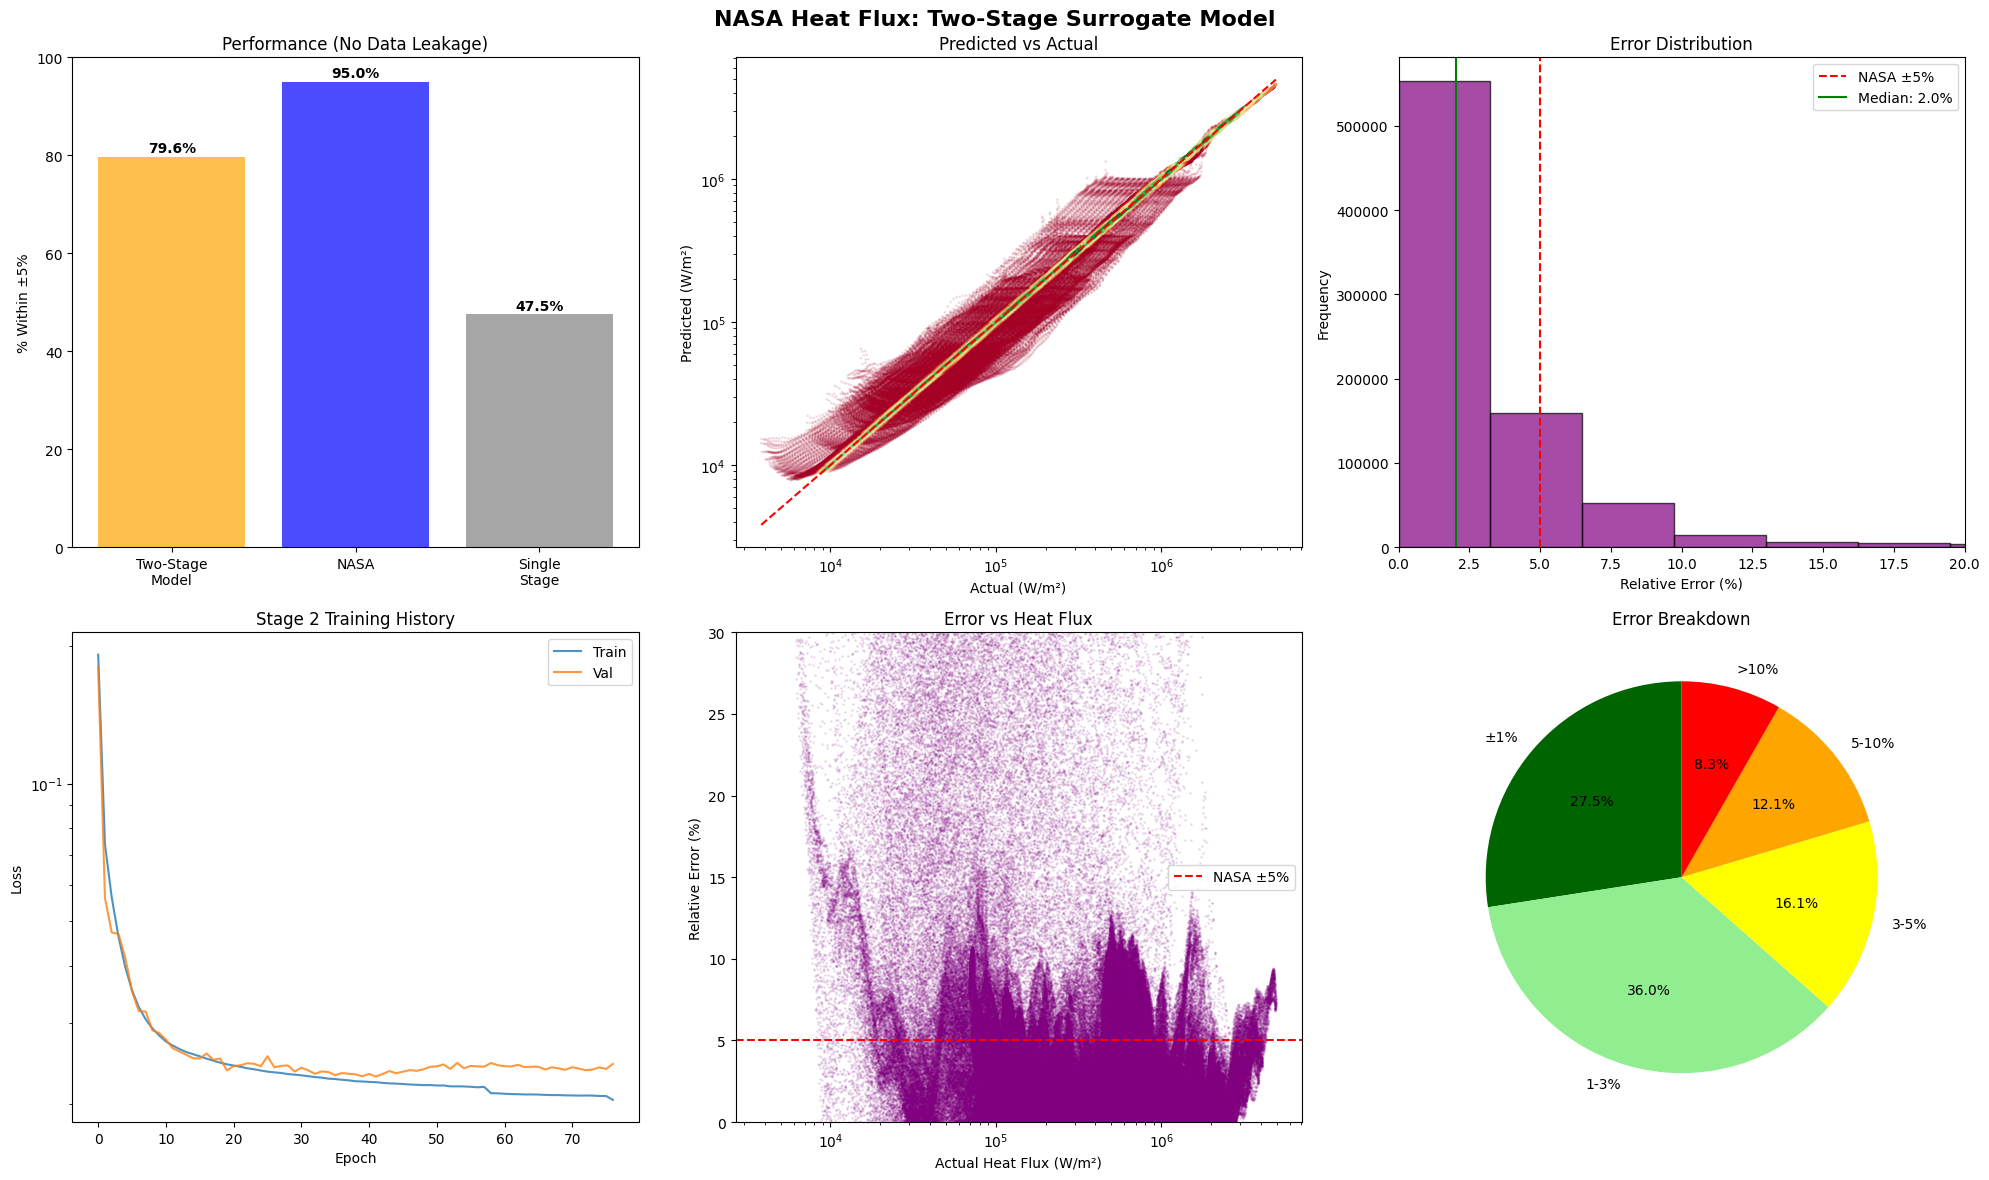


TWO-STAGE SURROGATE MODEL SUMMARY
Stage 1: Predict BL properties (theta/delta/Me)
  → 149,507 parameters
  → 40 epochs

Stage 2: Predict heat flux from Stage 1 predictions
  → 317,697 parameters
  → 77 epochs

✓ NO actual CFD outputs used - only predictions!

Performance: 79.6% within ±5% (Target: 95%)

📈 GOOD: Much better than single-stage (79.6% vs 47.5%)

✅ Complete! Models saved
This approach breaks data leakage while capturing physics!


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("=== NASA APOLLO CFD - TWO-STAGE SURROGATE MODEL ===\n")
print("Breaking Data Leakage Strategy:")
print("  STAGE 1: Predict theta/delta/Me from true inputs")
print("  STAGE 2: Predict heat flux using Stage 1 predictions")
print("  → No actual CFD outputs used as inputs!")
print("  → Captures physics without leakage\n")

# Mount Google Drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/NASA/apollo_cfd_database.csv"

df = pd.read_csv(file_path)
print(f"Dataset shape: {df.shape}")

# ============================================================================
# STEP 1: DATA CLEANING
# ============================================================================
print(f"\n=== DATA CLEANING ===")
print(f"Original: {len(df):,} points")

df_clean = df.copy()
df_clean = df_clean[df_clean['theta (m)'] >= 0]
df_clean = df_clean[df_clean['Re-theta'] >= 1e-5]
df_clean = df_clean[(df_clean['qw (W/m^2)'] >= 1e3) & (df_clean['qw (W/m^2)'] <= 1e7)]

print(f"Removed: {len(df) - len(df_clean):,} points")
print(f"Clean: {len(df_clean):,} points")

# ============================================================================
# STEP 2: FEATURE ENGINEERING FOR STAGE 1
# ============================================================================
print(f"\n=== FEATURE ENGINEERING ===")

# Primary inputs
df_clean['log_density'] = np.log10(df_clean['density (kg/m^3)'])
df_clean['log_velocity'] = np.log10(df_clean['velocity (m/s)'])

# Geometry
df_clean['radial_dist'] = np.sqrt(df_clean['X']**2 + df_clean['Y']**2)
df_clean['char_length'] = np.sqrt(df_clean['X']**2 + df_clean['Y']**2 + df_clean['Z']**2)

stagnation_z = df_clean['Z'].min()
df_clean['dist_from_stagnation'] = np.sqrt(df_clean['X']**2 + df_clean['Y']**2 +
                                            (df_clean['Z'] - stagnation_z)**2)
df_clean['log_dist_stagnation'] = np.log10(df_clean['dist_from_stagnation'] + 1e-10)

max_radius = df_clean['radial_dist'].max()
df_clean['norm_radial'] = df_clean['radial_dist'] / (max_radius + 1e-10)

df_clean['effective_radius'] = np.where(
    df_clean['radial_dist'] > 0.01,
    df_clean['radial_dist'] * (1.4 / max_radius),
    0.1
)
df_clean['log_radius'] = np.log10(df_clean['effective_radius'] + 1e-10)

# Reynolds
MU_REF = 1.8e-5
df_clean['reynolds'] = (df_clean['density (kg/m^3)'] * df_clean['velocity (m/s)'] *
                         df_clean['char_length']) / MU_REF
df_clean['log_reynolds'] = np.log10(df_clean['reynolds'] + 1e-10)
df_clean['sqrt_reynolds'] = np.sqrt(df_clean['reynolds'])

# Mach
df_clean['mach_sq'] = df_clean['mach (-)'] ** 2
df_clean['log_mach'] = np.log10(df_clean['mach (-)'] + 1e-10)

# Dynamic pressure
df_clean['log_dyn_pressure'] = np.log10(df_clean['dynamic_pressure (Pa)'])

# AOA
df_clean['cos_aoa'] = np.cos(np.radians(df_clean['aoa (degrees)']))
df_clean['sin_aoa'] = np.sin(np.radians(df_clean['aoa (degrees)']))

# Sutton-Graves
df_clean['sutton_graves'] = (np.sqrt(df_clean['density (kg/m^3)']) *
                              (df_clean['velocity (m/s)'] ** 3)) / (df_clean['char_length'] + 1e-10)
df_clean['log_sutton_graves'] = np.log10(df_clean['sutton_graves'] + 1e-10)

# Interaction
df_clean['mach_reynolds'] = df_clean['log_mach'] * df_clean['log_reynolds']

# Stage 1 input features (for predicting BL properties)
stage1_features = [
    'log_density', 'log_velocity',
    'mach_sq', 'log_mach',
    'log_dyn_pressure',
    'cos_aoa', 'sin_aoa',
    'char_length', 'dist_from_stagnation', 'log_dist_stagnation',
    'norm_radial', 'log_radius',
    'log_reynolds', 'sqrt_reynolds',
    'log_sutton_graves',
    'mach_reynolds'
]

# Stage 1 targets (boundary layer properties to predict)
stage1_targets = ['theta (m)', 'delta (m)', 'Me']

print(f"Stage 1 features: {len(stage1_features)}")
print(f"Stage 1 targets: {stage1_targets}")

# ============================================================================
# STEP 3: TRAJECTORY STATE SPLIT
# ============================================================================
print(f"\n=== TRAJECTORY STATE SPLIT ===")

VEL = 'velocity (m/s)'
RHO = 'density (kg/m^3)'
AOA = 'aoa (degrees)'

states = df_clean[[VEL, RHO, AOA]].drop_duplicates().reset_index(drop=True)
print(f"Unique states: {len(states)}")

velocity_bins = pd.qcut(df_clean[VEL], q=5, labels=['v1','v2','v3','v4','v5'], duplicates='drop')
df_clean['vel_bin'] = velocity_bins

test_keys = set()
neighbor_lock = set()

for aoa, grp in states.groupby(AOA, sort=False):
    g = grp.sort_values([VEL, RHO], ascending=[False, True]).reset_index(drop=True)
    n = len(g)
    if n <= 2:
        continue

    mid_idx = np.arange(1, n-1)
    k = max(1, int(round(0.10 * len(mid_idx))))
    pick_pos = np.linspace(0, len(mid_idx)-1, k, dtype=int)

    for i in mid_idx[pick_pos]:
        key = tuple(g.loc[i, [VEL, RHO, AOA]])
        left = tuple(g.loc[i-1, [VEL, RHO, AOA]])
        right = tuple(g.loc[i+1, [VEL, RHO, AOA]])
        test_keys.add(key)
        neighbor_lock.add(left)
        neighbor_lock.add(right)

remaining = states[~states.apply(lambda r: tuple(r) in test_keys, axis=1)]
remain_locked = remaining[remaining.apply(lambda r: tuple(r) in neighbor_lock, axis=1)]
remain_free = remaining[~remaining.apply(lambda r: tuple(r) in neighbor_lock, axis=1)]

target_val = int(round(0.10 * len(states)))

if len(remain_free) <= target_val:
    val_states = remain_free
else:
    parts = []
    for aoa, grp in remain_free.groupby(AOA, sort=False):
        take = int(round(target_val * len(grp) / len(remain_free)))
        take = min(take, len(grp))
        if take > 0:
            parts.append(grp.sample(n=take, random_state=42))
    val_states = pd.concat(parts).drop_duplicates()
    if len(val_states) > target_val:
        val_states = val_states.sample(n=target_val, random_state=42)

train_states = pd.concat([remain_locked, remain_free[~remain_free.index.isin(val_states.index)]]).drop_duplicates()

train_keys = set(map(tuple, train_states[[VEL, RHO, AOA]].to_numpy()))
val_keys = set(map(tuple, val_states[[VEL, RHO, AOA]].to_numpy()))

df_clean['state_key'] = list(zip(df_clean[VEL], df_clean[RHO], df_clean[AOA]))

df_clean['split'] = 'other'
df_clean.loc[df_clean['state_key'].isin(test_keys), 'split'] = 'test'
df_clean.loc[df_clean['state_key'].isin(val_keys), 'split'] = 'val'
df_clean.loc[df_clean['state_key'].isin(train_keys), 'split'] = 'train'

df_clean.drop('state_key', axis=1, inplace=True)

print(df_clean['split'].value_counts())

train_df = df_clean[df_clean['split'] == 'train']
val_df = df_clean[df_clean['split'] == 'val']
test_df = df_clean[df_clean['split'] == 'test']

# ============================================================================
# STEP 4: PREPARE DATA FOR STAGE 1
# ============================================================================
print(f"\n=== STAGE 1: DATA PREPARATION ===")

import gc
gc.collect()

# Stage 1: Predict boundary layer properties
X_train_s1 = train_df[stage1_features].values.astype(np.float32)
y_train_s1 = train_df[stage1_targets].values.astype(np.float32)
X_val_s1 = val_df[stage1_features].values.astype(np.float32)
y_val_s1 = val_df[stage1_targets].values.astype(np.float32)
X_test_s1 = test_df[stage1_features].values.astype(np.float32)
y_test_s1 = test_df[stage1_targets].values.astype(np.float32)

# Log transform targets for better training
y_train_s1_log = np.log10(y_train_s1 + 1e-10)
y_val_s1_log = np.log10(y_val_s1 + 1e-10)
y_test_s1_log = np.log10(y_test_s1 + 1e-10)

# Scale
scaler_X_s1 = StandardScaler()
X_train_s1_scaled = scaler_X_s1.fit_transform(X_train_s1).astype(np.float32)
X_val_s1_scaled = scaler_X_s1.transform(X_val_s1).astype(np.float32)
X_test_s1_scaled = scaler_X_s1.transform(X_test_s1).astype(np.float32)

scaler_y_s1 = StandardScaler()
y_train_s1_scaled = scaler_y_s1.fit_transform(y_train_s1_log).astype(np.float32)
y_val_s1_scaled = scaler_y_s1.transform(y_val_s1_log).astype(np.float32)
y_test_s1_scaled = scaler_y_s1.transform(y_test_s1_log).astype(np.float32)

print(f"Stage 1 training: {X_train_s1_scaled.shape}")

# ============================================================================
# STEP 5: BUILD AND TRAIN STAGE 1 MODEL
# ============================================================================
print(f"\n=== STAGE 1: BUILDING BL PROPERTY PREDICTOR ===")

def create_stage1_model(input_shape, output_shape):
    inputs = layers.Input(shape=(input_shape,))

    x = layers.Dense(384, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0002))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0002))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_shape)(x)  # Multi-output

    return keras.Model(inputs, outputs)

model_stage1 = create_stage1_model(X_train_s1_scaled.shape[1], len(stage1_targets))

optimizer_s1 = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model_stage1.compile(optimizer=optimizer_s1, loss='mse', metrics=['mae'])

print(f"Stage 1 Parameters: {model_stage1.count_params():,}")

print(f"\n=== STAGE 1: TRAINING ===")

callbacks_s1 = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-7, verbose=1),
]

history_s1 = model_stage1.fit(
    X_train_s1_scaled, y_train_s1_scaled,
    validation_data=(X_val_s1_scaled, y_val_s1_scaled),
    epochs=150,
    batch_size=16384,
    callbacks=callbacks_s1,
    verbose=2
)

print(f"✅ Stage 1 complete: {len(history_s1.history['loss'])} epochs")

# ============================================================================
# STEP 6: GENERATE STAGE 1 PREDICTIONS
# ============================================================================
print(f"\n=== GENERATING STAGE 1 PREDICTIONS ===")

# Predict on ALL splits (train, val, test)
pred_train_s1_scaled = model_stage1.predict(X_train_s1_scaled, verbose=0)
pred_val_s1_scaled = model_stage1.predict(X_val_s1_scaled, verbose=0)
pred_test_s1_scaled = model_stage1.predict(X_test_s1_scaled, verbose=0)

# Inverse transform
pred_train_s1_log = scaler_y_s1.inverse_transform(pred_train_s1_scaled)
pred_val_s1_log = scaler_y_s1.inverse_transform(pred_val_s1_scaled)
pred_test_s1_log = scaler_y_s1.inverse_transform(pred_test_s1_scaled)

pred_train_s1 = 10**pred_train_s1_log
pred_val_s1 = 10**pred_val_s1_log
pred_test_s1 = 10**pred_test_s1_log

print(f"Generated predictions for theta, delta, Me")
print(f"Train: {pred_train_s1.shape}, Val: {pred_val_s1.shape}, Test: {pred_test_s1.shape}")

# ============================================================================
# STEP 7: PREPARE DATA FOR STAGE 2
# ============================================================================
print(f"\n=== STAGE 2: DATA PREPARATION ===")

# Add predicted BL properties as features
pred_theta_train = pred_train_s1[:, 0]
pred_delta_train = pred_train_s1[:, 1]
pred_me_train = pred_train_s1[:, 2]

pred_theta_val = pred_val_s1[:, 0]
pred_delta_val = pred_val_s1[:, 1]
pred_me_val = pred_val_s1[:, 2]

pred_theta_test = pred_test_s1[:, 0]
pred_delta_test = pred_test_s1[:, 1]
pred_me_test = pred_test_s1[:, 2]

# Create Stage 2 features: original + predicted BL properties
X_train_s2 = np.column_stack([
    X_train_s1,
    np.log10(pred_theta_train + 1e-10),
    np.log10(pred_delta_train + 1e-10),
    np.log10(pred_me_train + 1e-10)
]).astype(np.float32)

X_val_s2 = np.column_stack([
    X_val_s1,
    np.log10(pred_theta_val + 1e-10),
    np.log10(pred_delta_val + 1e-10),
    np.log10(pred_me_val + 1e-10)
]).astype(np.float32)

X_test_s2 = np.column_stack([
    X_test_s1,
    np.log10(pred_theta_test + 1e-10),
    np.log10(pred_delta_test + 1e-10),
    np.log10(pred_me_test + 1e-10)
]).astype(np.float32)

# Heat flux targets
y_train_s2 = train_df['qw (W/m^2)'].values.astype(np.float32)
y_val_s2 = val_df['qw (W/m^2)'].values.astype(np.float32)
y_test_s2 = test_df['qw (W/m^2)'].values.astype(np.float32)

# Scale
scaler_X_s2 = StandardScaler()
X_train_s2_scaled = scaler_X_s2.fit_transform(X_train_s2).astype(np.float32)
X_val_s2_scaled = scaler_X_s2.transform(X_val_s2).astype(np.float32)
X_test_s2_scaled = scaler_X_s2.transform(X_test_s2).astype(np.float32)

y_train_s2_log = np.log10(y_train_s2).astype(np.float32)
y_val_s2_log = np.log10(y_val_s2).astype(np.float32)
y_test_s2_log = np.log10(y_test_s2).astype(np.float32)

scaler_y_s2 = StandardScaler()
y_train_s2_scaled = scaler_y_s2.fit_transform(y_train_s2_log.reshape(-1, 1)).flatten().astype(np.float32)
y_val_s2_scaled = scaler_y_s2.transform(y_val_s2_log.reshape(-1, 1)).flatten().astype(np.float32)
y_test_s2_scaled = scaler_y_s2.transform(y_test_s2_log.reshape(-1, 1)).flatten().astype(np.float32)

print(f"Stage 2 training: {X_train_s2_scaled.shape} (includes predicted BL properties)")

del X_train_s1, X_val_s1, X_test_s1
gc.collect()

# ============================================================================
# STEP 8: BUILD AND TRAIN STAGE 2 MODEL
# ============================================================================
print(f"\n=== STAGE 2: BUILDING HEAT FLUX PREDICTOR ===")

def create_stage2_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))

    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Residual block
    shortcut = layers.Dense(256)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

def balanced_loss(y_true, y_pred):
    mse = tf.square(y_true - y_pred)
    magnitude_weight = 1.0 + 0.5 * tf.abs(y_true) / (tf.reduce_mean(tf.abs(y_true)) + 1e-7)
    return tf.reduce_mean(magnitude_weight * mse)

model_stage2 = create_stage2_model(X_train_s2_scaled.shape[1])

optimizer_s2 = keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
model_stage2.compile(optimizer=optimizer_s2, loss=balanced_loss, metrics=['mae'])

print(f"Stage 2 Parameters: {model_stage2.count_params():,}")

print(f"\n=== STAGE 2: TRAINING ===")

callbacks_s2 = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=18, min_lr=1e-8, verbose=1),
    keras.callbacks.ModelCheckpoint('best_stage2_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

history_s2 = model_stage2.fit(
    X_train_s2_scaled, y_train_s2_scaled,
    validation_data=(X_val_s2_scaled, y_val_s2_scaled),
    epochs=200,
    batch_size=16384,
    callbacks=callbacks_s2,
    verbose=2
)

print(f"✅ Stage 2 complete: {len(history_s2.history['loss'])} epochs")

# ============================================================================
# STEP 9: EVALUATE
# ============================================================================
print(f"\n=== FINAL EVALUATION ===")

y_pred_scaled = model_stage2.predict(X_test_s2_scaled, verbose=0)
y_pred_log = scaler_y_s2.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_pred = 10**y_pred_log

mae = mean_absolute_error(y_test_s2, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_s2, y_pred))

rel_errors = np.abs(y_test_s2 - y_pred) / y_test_s2 * 100

pct_1 = np.sum(rel_errors <= 1) / len(rel_errors) * 100
pct_3 = np.sum(rel_errors <= 3) / len(rel_errors) * 100
pct_5 = np.sum(rel_errors <= 5) / len(rel_errors) * 100
pct_10 = np.sum(rel_errors <= 10) / len(rel_errors) * 100

median_err = np.median(rel_errors)
q95_err = np.percentile(rel_errors, 95)

print(f"\n{'='*60}")
print(f"TWO-STAGE MODEL RESULTS")
print(f"{'='*60}")
print(f"MAE: {mae:.0f} W/m²")
print(f"RMSE: {rmse:.0f} W/m²")
print(f"Within ±1%: {pct_1:.1f}%")
print(f"Within ±3%: {pct_3:.1f}%")
print(f"Within ±5%: {pct_5:.1f}% ⭐ (NASA: 95%)")
print(f"Within ±10%: {pct_10:.1f}%")
print(f"Median error: {median_err:.2f}%")
print(f"95th %ile: {q95_err:.1f}%")
print(f"{'='*60}")

# ============================================================================
# STEP 10: VISUALIZE
# ============================================================================
print(f"\n=== VISUALIZATIONS ===")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('NASA Heat Flux: Two-Stage Surrogate Model', fontsize=16, fontweight='bold')

# 1. Performance
bars = axes[0,0].bar(['Two-Stage\nModel', 'NASA', 'Single\nStage'], [pct_5, 95.0, 47.5],
                     color=['green' if pct_5>=95 else 'orange', 'blue', 'gray'], alpha=0.7)
axes[0,0].set_ylabel('% Within ±5%')
axes[0,0].set_title('Performance (No Data Leakage)')
axes[0,0].set_ylim(0, 100)
for bar, val in zip(bars, [pct_5, 95.0, 47.5]):
    axes[0,0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
                   f'{val:.1f}%', ha='center', fontweight='bold')

# 2. Predicted vs Actual
axes[0,1].scatter(y_test_s2, y_pred, alpha=0.1, s=1, c=rel_errors, cmap='RdYlGn_r', vmin=0, vmax=10)
axes[0,1].plot([y_test_s2.min(), y_test_s2.max()], [y_test_s2.min(), y_test_s2.max()], 'r--')
axes[0,1].set_xlabel('Actual (W/m²)')
axes[0,1].set_ylabel('Predicted (W/m²)')
axes[0,1].set_title('Predicted vs Actual')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')

# 3. Error distribution
axes[0,2].hist(rel_errors, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[0,2].axvline(5, color='red', linestyle='--', label='NASA ±5%')
axes[0,2].axvline(median_err, color='green', linestyle='-', label=f'Median: {median_err:.1f}%')
axes[0,2].set_xlabel('Relative Error (%)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Error Distribution')
axes[0,2].legend()
axes[0,2].set_xlim(0, 20)

# 4. Stage 2 training history
axes[1,0].plot(history_s2.history['loss'], label='Train', alpha=0.8)
axes[1,0].plot(history_s2.history['val_loss'], label='Val', alpha=0.8)
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].set_title('Stage 2 Training History')
axes[1,0].legend()
axes[1,0].set_yscale('log')

# 5. Error vs magnitude
axes[1,1].scatter(y_test_s2, rel_errors, alpha=0.1, s=1, color='purple')
axes[1,1].axhline(5, color='red', linestyle='--', label='NASA ±5%')
axes[1,1].set_xlabel('Actual Heat Flux (W/m²)')
axes[1,1].set_ylabel('Relative Error (%)')
axes[1,1].set_title('Error vs Heat Flux')
axes[1,1].set_xscale('log')
axes[1,1].set_ylim(0, 30)
axes[1,1].legend()

# 6. Error breakdown
w1 = pct_1
w3 = pct_3 - pct_1
w5 = pct_5 - pct_3
w10 = pct_10 - pct_5
above = 100 - pct_10

axes[1,2].pie([w1, w3, w5, w10, above], labels=['±1%', '1-3%', '3-5%', '5-10%', '>10%'],
              colors=['darkgreen', 'lightgreen', 'yellow', 'orange', 'red'],
              autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Error Breakdown')

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*60}")
print(f"TWO-STAGE SURROGATE MODEL SUMMARY")
print(f"{'='*60}")
print(f"Stage 1: Predict BL properties (theta/delta/Me)")
print(f"  → {model_stage1.count_params():,} parameters")
print(f"  → {len(history_s1.history['loss'])} epochs")
print(f"\nStage 2: Predict heat flux from Stage 1 predictions")
print(f"  → {model_stage2.count_params():,} parameters")
print(f"  → {len(history_s2.history['loss'])} epochs")
print(f"\n✓ NO actual CFD outputs used - only predictions!")
print(f"\nPerformance: {pct_5:.1f}% within ±5% (Target: 95%)")

if pct_5 >= 95:
    print(f"\n🎉 SUCCESS: Beat NASA baseline!")
elif pct_5 >= 85:
    print(f"\n💪 EXCELLENT: Strong two-stage performance!")
elif pct_5 >= 70:
    print(f"\n📈 GOOD: Much better than single-stage ({pct_5:.1f}% vs 47.5%)")
else:
    print(f"\n📊 Improvement: {pct_5 - 47.5:.1f}% over single-stage")

print(f"\n✅ Complete! Models saved")
print(f"This approach breaks data leakage while capturing physics!")